YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


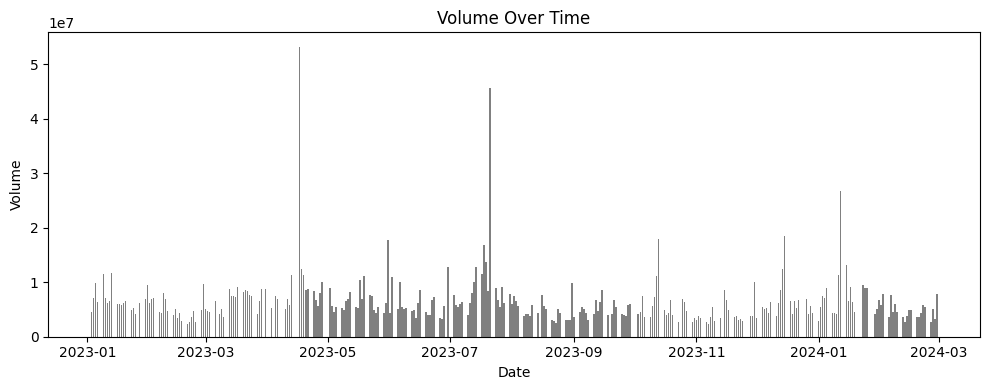

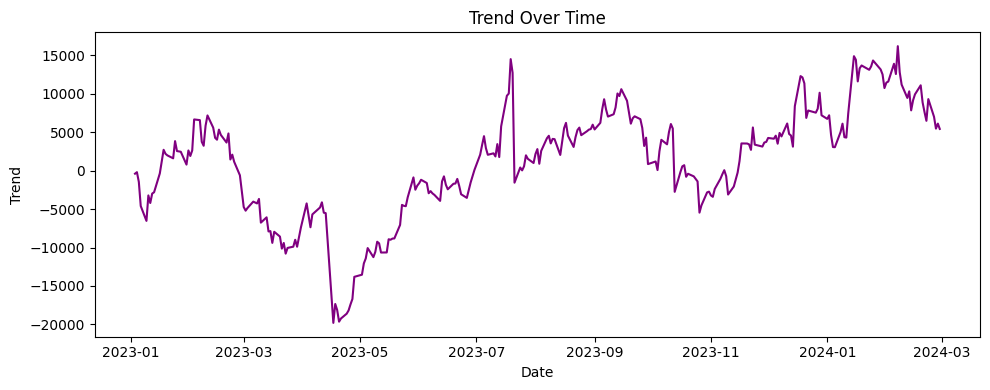

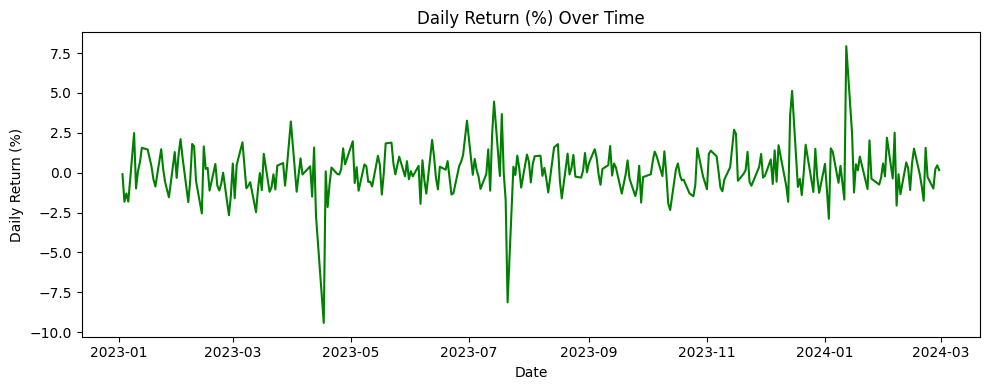

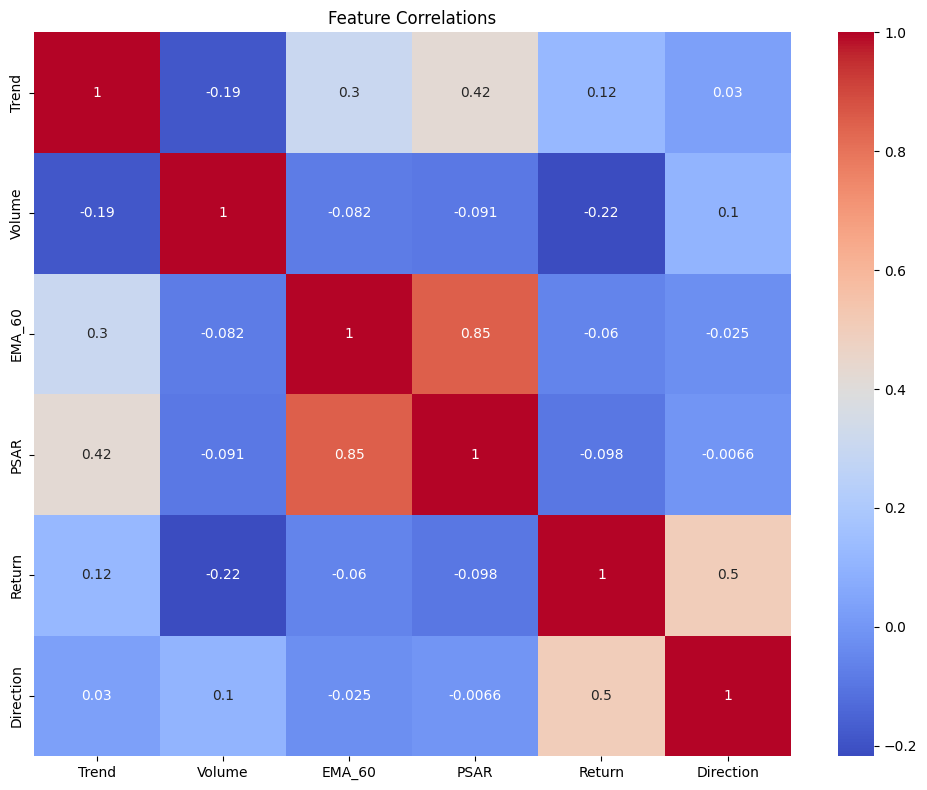

C:\Users\KIIT\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.5096 - loss: 0.6894 - val_accuracy: 0.4821 - val_loss: 0.7075
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4817 - loss: 0.6962 - val_accuracy: 0.5179 - val_loss: 0.6999
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5658 - loss: 0.6866 - val_accuracy: 0.5179 - val_loss: 0.7009
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5664 - loss: 0.6854 - val_accuracy: 0.5179 - val_loss: 0.7076
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5581 - loss: 0.6860 - val_accuracy: 0.5179 - val_loss: 0.7113
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5006 - loss: 0.6929 - val_accuracy: 0.5179 - val_loss: 0.7135
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5864 - loss: 0.6701 - val_accuracy: 0.5000 - val_loss: 0.7161


Enter the number of months you want to predict:  3


[*********************100%***********************]  1 of 1 completed


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 861ms/step
R^2 Score for Future Prediction: 0.09


In [1]:
import datetime
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning Imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# ===============================
# Module 1: Data Fetching & Cleanup
# ===============================
def fetch_data(symbol, start, end):
    ticker = yf.download(symbol, start, end)
    df = pd.DataFrame(ticker)
    # Flatten multi-index columns if present
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    return df

# ===============================
# Module 2: Technical Indicators
# ===============================
def calculate_ema(data, period=60):
    """Return a DataFrame with column EMA_{period}."""
    multiplier = 2 / (period + 1)
    ema = pd.Series(index=data.index, dtype=np.float64)
    ema.iloc[0] = data['Close'].iloc[0]
    for i in range(1, len(data)):
        ema.iloc[i] = (data['Close'].iloc[i] * multiplier) + (ema.iloc[i-1] * (1 - multiplier))
    return pd.DataFrame({f'EMA_{period}': ema}, index=data.index)

def calculate_parabolic_sar(data, af=0.02, af_max=0.2):
    """Return a DataFrame with column 'PSAR' computed from data."""
    high = data['High'].values
    low = data['Low'].values
    n = len(data)
    psar = np.zeros(n, dtype=np.float64)
    trend = np.ones(n)  # 1: uptrend, -1: downtrend
    ep = np.zeros(n, dtype=np.float64)
    af_current = af
    psar[0] = low[0]
    ep[0] = high[0]
    for i in range(1, n):
        psar[i] = psar[i-1] + af_current * (ep[i-1] - psar[i-1])
        if trend[i-1] == 1:
            if i >= 2:
                psar[i] = min(psar[i], low[i-1], low[i-2])
            else:
                psar[i] = min(psar[i], low[i-1])
        else:
            if i >= 2:
                psar[i] = max(psar[i], high[i-1], high[i-2])
            else:
                psar[i] = max(psar[i], high[i-1])
        if trend[i-1] == 1:
            if low[i] < psar[i]:
                trend[i] = -1
                psar[i] = ep[i-1]
                ep[i] = low[i]
                af_current = af
            else:
                trend[i] = 1
                if high[i] > ep[i-1]:
                    ep[i] = high[i]
                    af_current = min(af_current + af, af_max)
                else:
                    ep[i] = ep[i-1]
        else:
            if high[i] > psar[i]:
                trend[i] = 1
                psar[i] = ep[i-1]
                ep[i] = high[i]
                af_current = af
            else:
                trend[i] = -1
                if low[i] < ep[i-1]:
                    ep[i] = low[i]
                    af_current = min(af_current + af, af_max)
                else:
                    ep[i] = ep[i-1]
    return pd.DataFrame({'PSAR': psar}, index=data.index)

# ===============================
# Module 3: Construct Signals (Combine Indicators & Features)
# ===============================
def construct_signals(data, ema_period=60, psar_af=0.02, psar_af_max=0.2):
    data = data.copy()
    ema_df = calculate_ema(data, ema_period)
    psar_df = calculate_parabolic_sar(data, psar_af, psar_af_max)
    
    data = data.join(ema_df)
    data = data.join(psar_df)
    
    # Compute additional features:
    data['Trend'] = (data['Open'] - data[f'EMA_{ema_period}']) * 100
    data['Return'] = data['Close'].pct_change() * 100
    data['Direction'] = np.where(data['Close'] > data['Open'], 1, -1)
    
    features = ['Trend', 'Volume', f'EMA_{ema_period}', 'PSAR', 'Return']
    data = data.dropna()
    return data[features + ['Direction']]

# ===============================
# Module 4: Create Sequences for LSTM from Multiple Features
# ===============================
# Modify create_sequences_multifeature to handle future data
def create_sequences_multifeature(data, feature_cols, sequence_length=10, is_future=False):
    X = []
    for i in range(len(data) - sequence_length):
        seq = data[feature_cols].iloc[i:i+sequence_length].values
        if not is_future:
            label = data['Direction'].iloc[i + sequence_length]  # For training data
            X.append((seq, label))
        else:
            X.append(seq)  # For future data, just append the sequence
    if is_future:
        return np.array(X), None  # For future, there's no 'Direction' column to return
    else:
        X, y = zip(*X)
        return np.array(X), np.array(y)
# ===============================
# Module 5: LSTM Model Training with Early Stopping
# ===============================
def build_lstm_model(input_shape, units1=50, units2=30, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units1, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units2))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_lstm_model(X_train, y_train, X_val, y_val, epochs=50, batch_size=16):
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_lstm_model(input_shape)
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=epochs, batch_size=batch_size, callbacks=[early_stop], verbose=1)
    return model, history
#The training stopped before reaching 50 epochs because an EarlyStopping callback was used. 
#This callback monitors the validation loss and stops training if there is no improvement for a specified number of epochs (in this case, 5 epochs). 
#This is done to prevent overfitting and save computation time.
# ===============================
# Module 6: Data Visualization
# ===============================
def plot_volume(data):
    plt.figure(figsize=(10,4))
    if 'Volume' in data.columns:
        plt.bar(data.index, data['Volume'], color='grey')
        plt.title('Volume Over Time')
        plt.xlabel('Date')
        plt.ylabel('Volume')
        plt.tight_layout()
        plt.show()
    else:
        print("Volume column not found.")

def plot_trend(data):
    plt.figure(figsize=(10,4))
    if 'Trend' in data.columns:
        plt.plot(data.index, data['Trend'], color='purple')
        plt.title('Trend Over Time')
        plt.xlabel('Date')
        plt.ylabel('Trend')
        plt.tight_layout()
        plt.show()
    else:
        print("Trend column not found.")

def plot_daily_return(data):
    plt.figure(figsize=(10,4))
    if 'Return' in data.columns:
        plt.plot(data.index, data['Return'], color='green')
        plt.title('Daily Return (%) Over Time')
        plt.xlabel('Date')
        plt.ylabel('Daily Return (%)')
        plt.tight_layout()
        plt.show()
    else:
        print("Return column not found.")

def plot_correlation_heatmap(data):
    plt.figure(figsize=(10,8))
    corr = data.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title('Feature Correlations')
    plt.tight_layout()
    plt.show()

# ===============================
# Main Execution
# ===============================
from sklearn.metrics import r2_score

# ===============================
# Main Execution
if __name__ == '__main__':
    # Set date range and symbol
    start_date = datetime.datetime(2023, 1, 1)
    end_date = datetime.datetime(2024, 3, 1)
    symbol = 'INFY.NS'
    
    # Fetch and process data
    raw_data = fetch_data(symbol, start_date, end_date)
    signals_data = construct_signals(raw_data, ema_period=60, psar_af=0.02, psar_af_max=0.2)
    signals_data_clean = signals_data.dropna()

     
    # Plot individual visualizations:
    plot_volume(signals_data_clean)
    plot_trend(signals_data_clean)
    plot_daily_return(signals_data_clean)
    plot_correlation_heatmap(signals_data_clean)
    

    # Prepare data for LSTM model using multiple features:
    feature_cols = ['Trend', 'EMA_60', 'PSAR', 'Volume', 'Return']
    
    # Convert Direction from {1, -1} to {1, 0} for binary classification
    signals_data_clean['Direction'] = np.where(signals_data_clean['Direction'] == 1, 1, 0)
    
    # Scale features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(signals_data_clean[feature_cols])
    scaled_df = pd.DataFrame(scaled_features, index=signals_data_clean.index, columns=feature_cols)
    # Add target column back
    scaled_df['Direction'] = signals_data_clean['Direction']
    
    # Create sequences from multiple features
    sequence_length = 10
    X, y = create_sequences_multifeature(scaled_df, feature_cols, sequence_length=sequence_length)
    
    # Split into training and validation sets (80/20 split)
    split_idx = int(len(X) * 0.8)
    X_train, X_val = X[:split_idx], X[split_idx:]
    y_train, y_val = y[:split_idx], y[split_idx:]
    
    # Build and train LSTM model with early stopping
    model, history = train_lstm_model(X_train, y_train, X_val, y_val, epochs=50, batch_size=16)
    
    # Now, predict for future data:
    # Get user input for prediction period
    months_to_predict = int(input("Enter the number of months you want to predict: "))
    future_start_date = end_date
    future_end_date = future_start_date + pd.DateOffset(months=months_to_predict)
    
    future_data = fetch_data(symbol, future_start_date, future_end_date)
    future_signals_clean = construct_signals(future_data, ema_period=60, psar_af=0.02, psar_af_max=0.2)
    future_signals_clean = future_signals_clean.dropna()
    
    # Scale future data using the same scaler
    future_scaled_features = scaler.transform(future_signals_clean[feature_cols])
    future_scaled_df = pd.DataFrame(future_scaled_features, index=future_signals_clean.index, columns=feature_cols)
    
    # Create sequences for future data (without 'Direction')
    X_future, _ = create_sequences_multifeature(future_scaled_df, feature_cols, sequence_length=sequence_length, is_future=True)
    
    # Predict future values
    future_predictions = model.predict(X_future)
    
    # Calculate R^2 score for the future predictions (using the actual future values as the target)
    from sklearn.metrics import r2_score
    actual_future_direction = future_signals_clean['Direction'].iloc[sequence_length:].values
    r2 = r2_score(actual_future_direction, (future_predictions > 0.5).astype(int))
    r2=abs(r2)
    print(f"R^2 Score for Future Prediction: {r2:.2f}")

In [2]:
import yfinance as yf

amd = yf.Ticker("AAPL")
amd_df = amd.history(period="max")
print(amd_df.head())


                               Open      High       Low     Close     Volume  \
Date                                                                           
1980-12-12 00:00:00-05:00  0.098597  0.099025  0.098597  0.098597  469033600   
1980-12-15 00:00:00-05:00  0.093881  0.093881  0.093453  0.093453  175884800   
1980-12-16 00:00:00-05:00  0.087022  0.087022  0.086594  0.086594  105728000   
1980-12-17 00:00:00-05:00  0.088737  0.089165  0.088737  0.088737   86441600   
1980-12-18 00:00:00-05:00  0.091309  0.091738  0.091309  0.091309   73449600   

                           Dividends  Stock Splits  
Date                                                
1980-12-12 00:00:00-05:00        0.0           0.0  
1980-12-15 00:00:00-05:00        0.0           0.0  
1980-12-16 00:00:00-05:00        0.0           0.0  
1980-12-17 00:00:00-05:00        0.0           0.0  
1980-12-18 00:00:00-05:00        0.0           0.0  
